In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.toy_data import *
from src.abstain import *

import sklearn
import pandas as pd

from operator import xor
from collections import defaultdict


# 4D Regret

In [2]:
true_labels = {
    (0, 0, 0, 0): 0,
    (0, 0, 0, 1): 0,
    (0, 0, 1, 0): 0,
    (0, 0, 1, 1): 0,
    (0, 1, 0, 0): 0,
    (0, 1, 0, 1): 1,
    (0, 1, 1, 0): 1,
    (0, 1, 1, 1): 1,
    (1, 0, 0, 0): 1,
    (1, 0, 0, 1): 1,
    (1, 0, 1, 0): 1,
    (1, 0, 1, 1): 1,
    (1, 1, 0, 0): 1,
    (1, 1, 0, 1): 1,
    (1, 1, 1, 0): 0,
    (1, 1, 1, 1): 0
}

instances_counts = {
    (0, 0, 0, 0): 5,
    (0, 0, 0, 1): 10,
    (0, 0, 1, 0): 10,
    (0, 0, 1, 1): 15,
    (0, 1, 0, 0): 10,
    (0, 1, 0, 1): 15,
    (0, 1, 1, 0): 10,
    (0, 1, 1, 1): 25,
    (1, 0, 0, 0): 10,
    (1, 0, 0, 1): 10,
    (1, 0, 1, 0): 10,
    (1, 0, 1, 1): 15,
    (1, 1, 0, 0): 15,
    (1, 1, 0, 1): 20,
    (1, 1, 1, 0): 15,
    (1, 1, 1, 1): 35
}

X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))

In [3]:
d = 4  # number of dimensions
m = 100 #number of retrainings
n_draws = 10
max_iter = 1000
noise_type = "class_conditional"
loss_type = "0-1"


In [4]:
metrics_dfs = []
instance_metrics_dfs = []
class_metrics_dfs = []

for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.49]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)

metrics_df = pd.concat(metrics_dfs)
instance_metrics_df = pd.concat(instance_metrics_dfs)
class_metrics_df = pd.concat(class_metrics_dfs)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

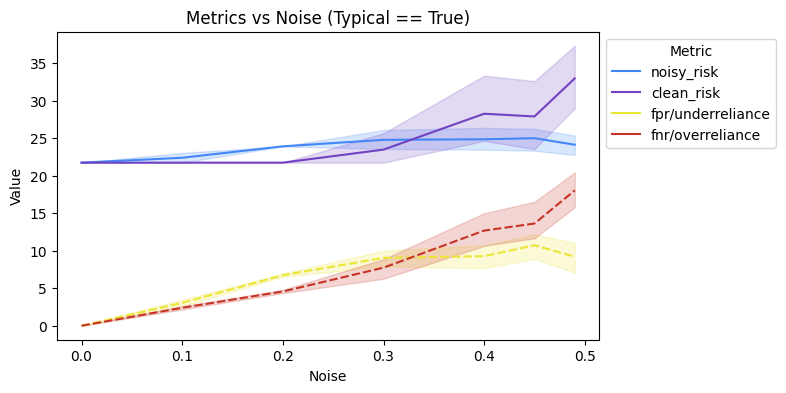

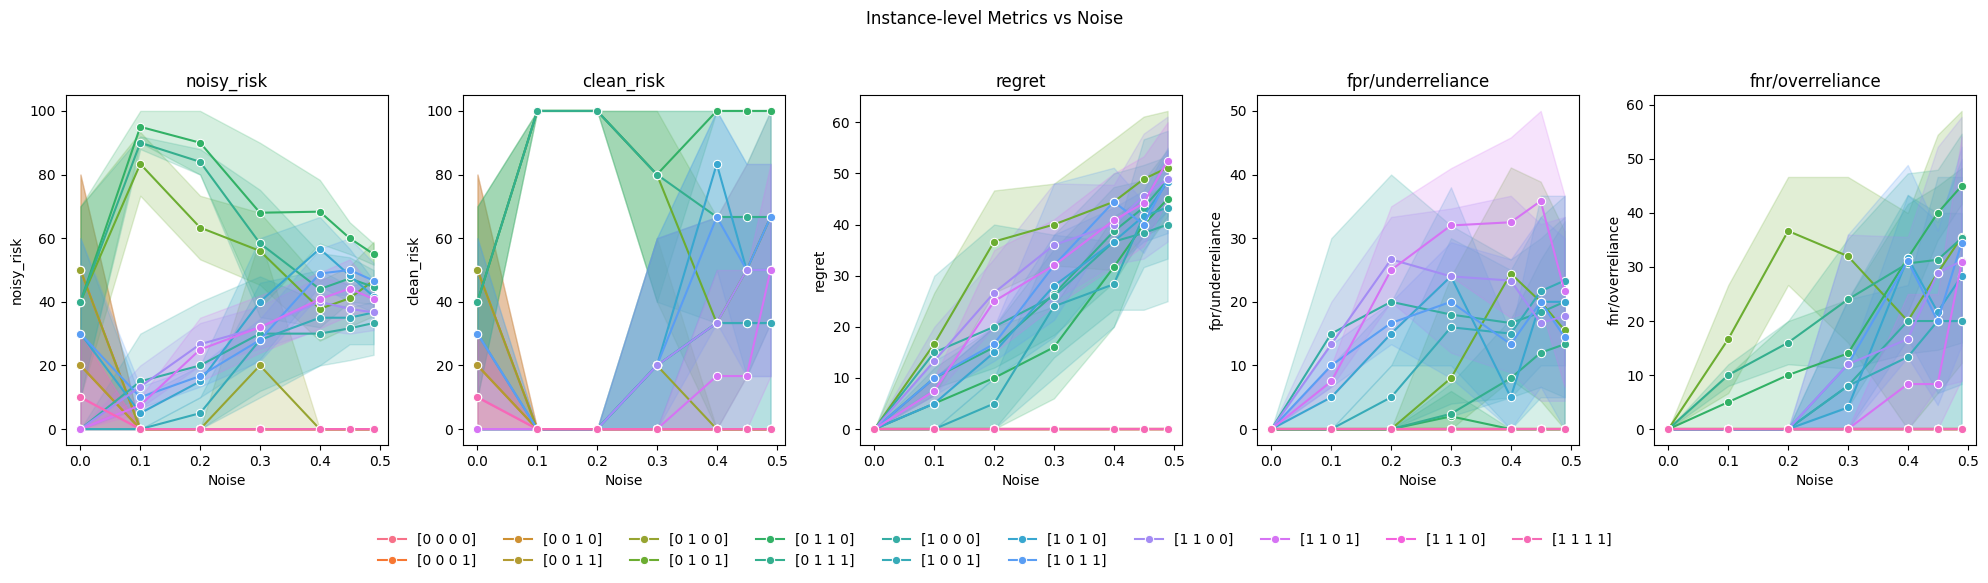

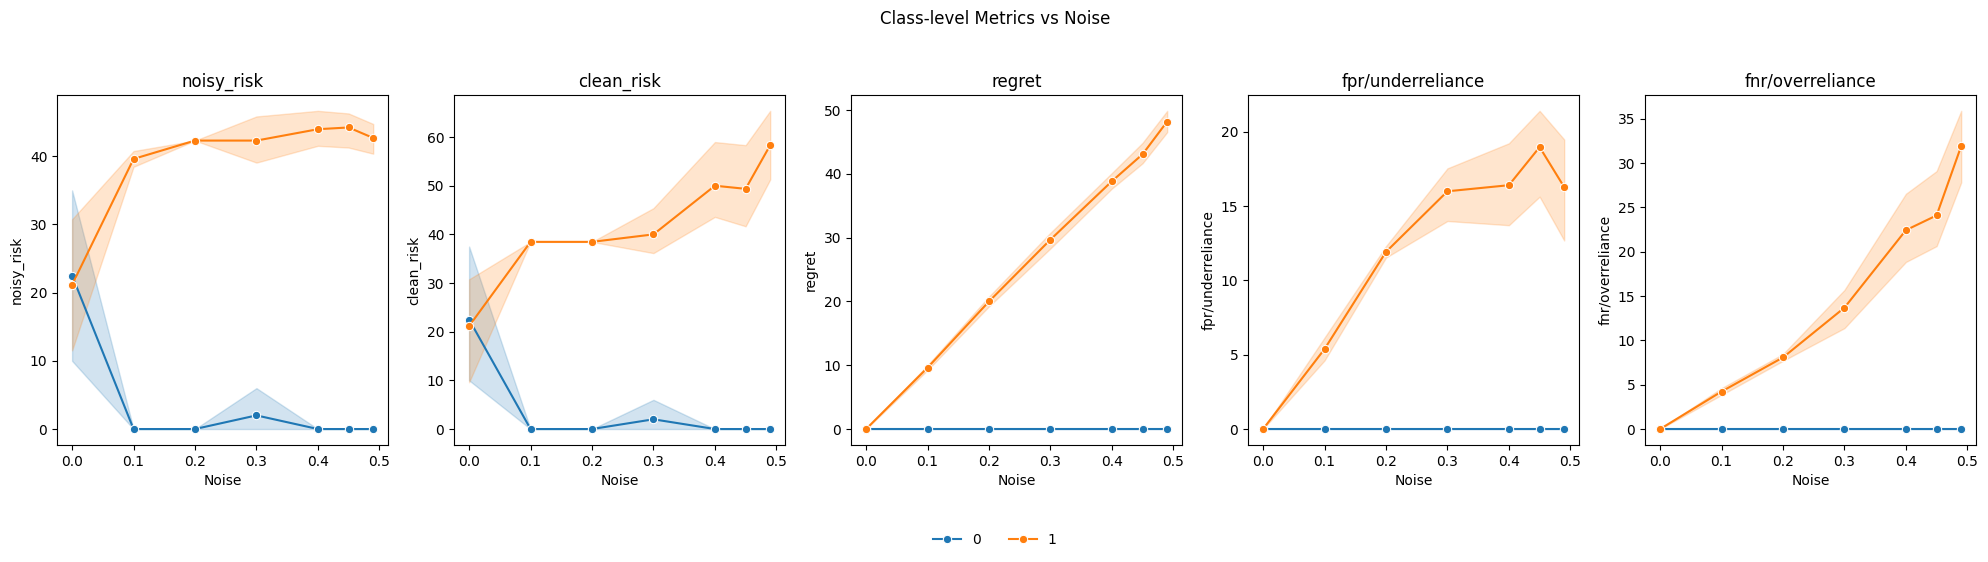

In [5]:
# Example usage
plot_regret_toy(metrics_df, instance_metrics_df, class_metrics_df)

# 4D Abstain

  0%|          | 0/100 [00:00<?, ?it/s]

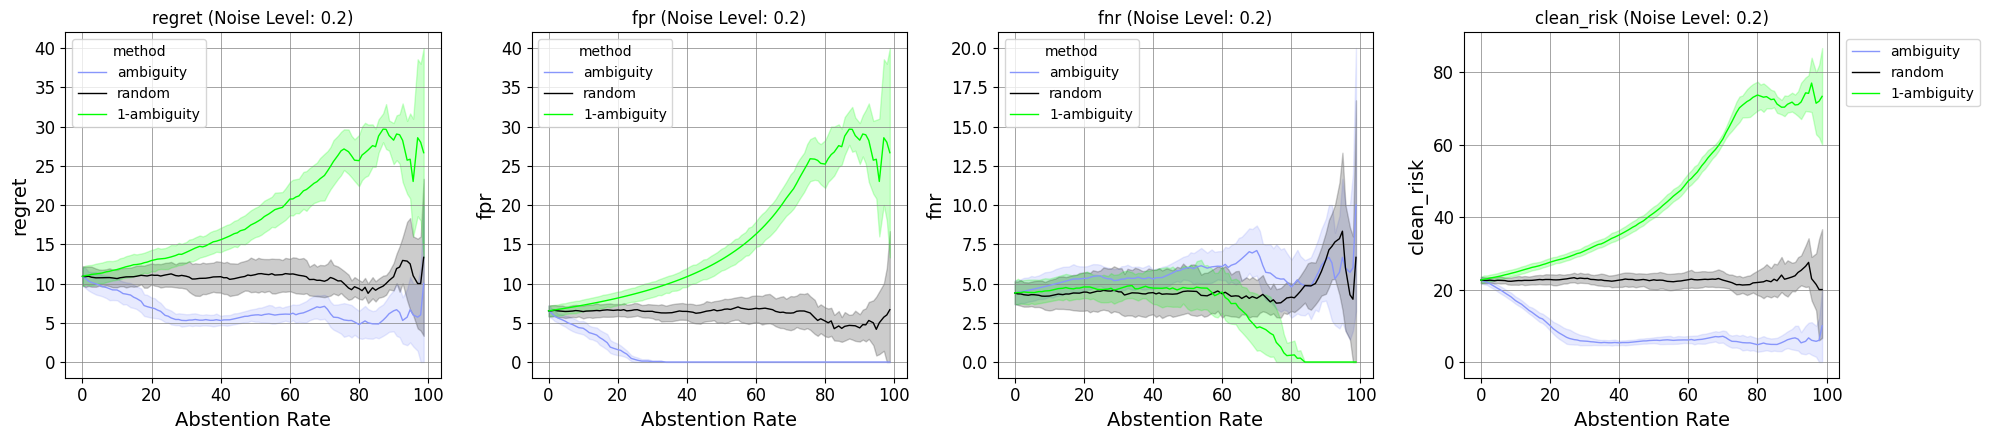

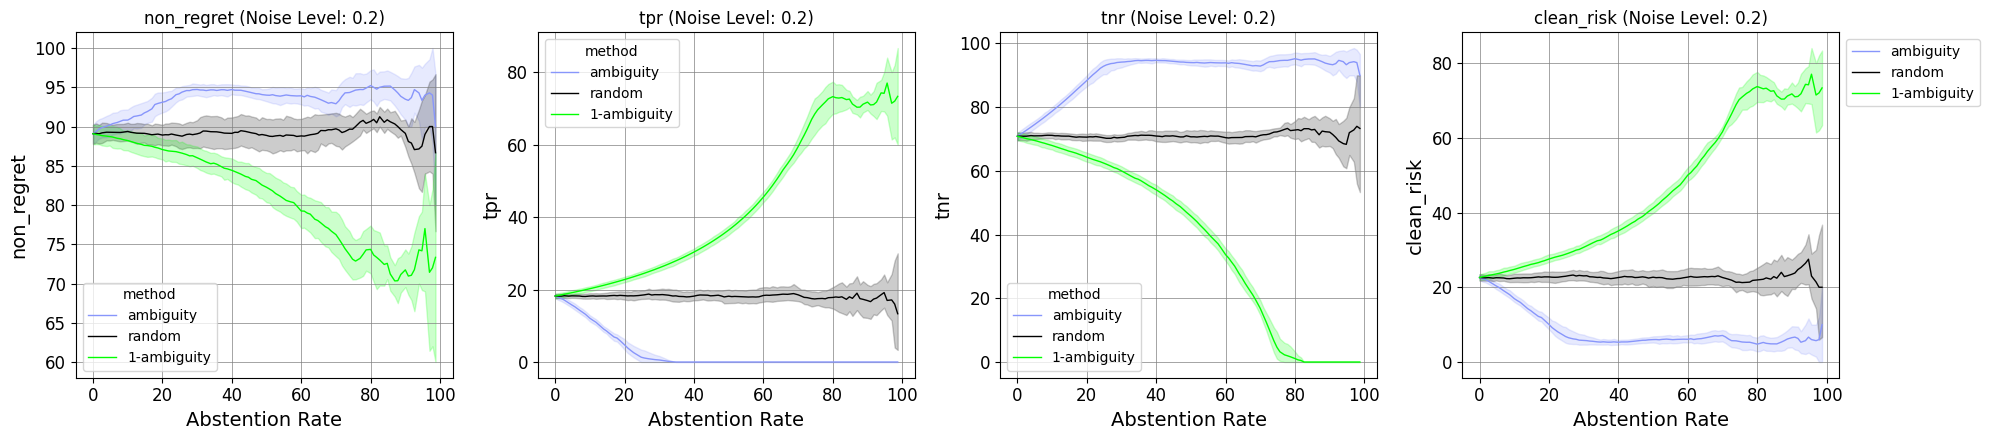

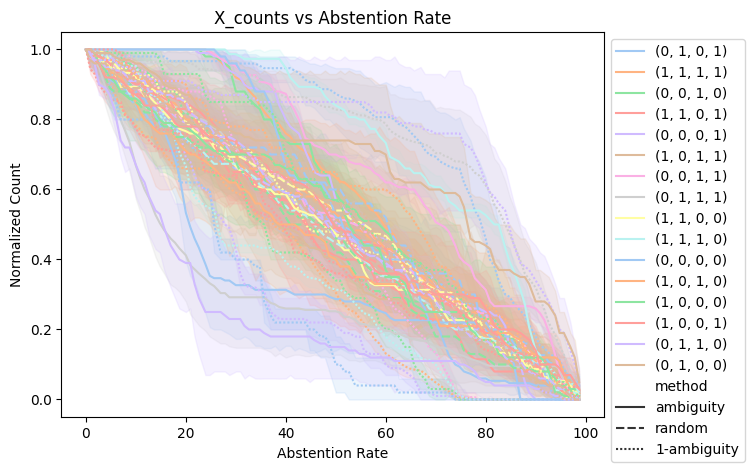

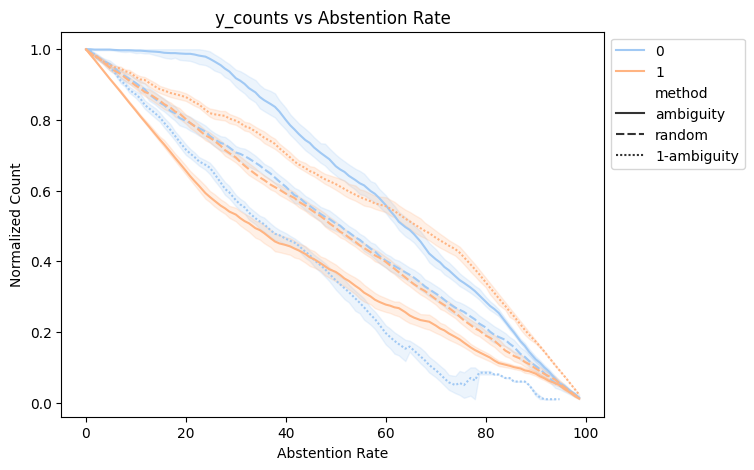

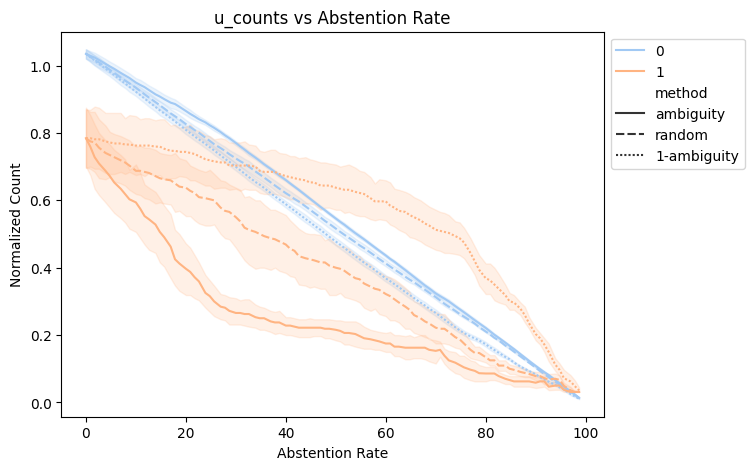

  0%|          | 0/100 [00:00<?, ?it/s]

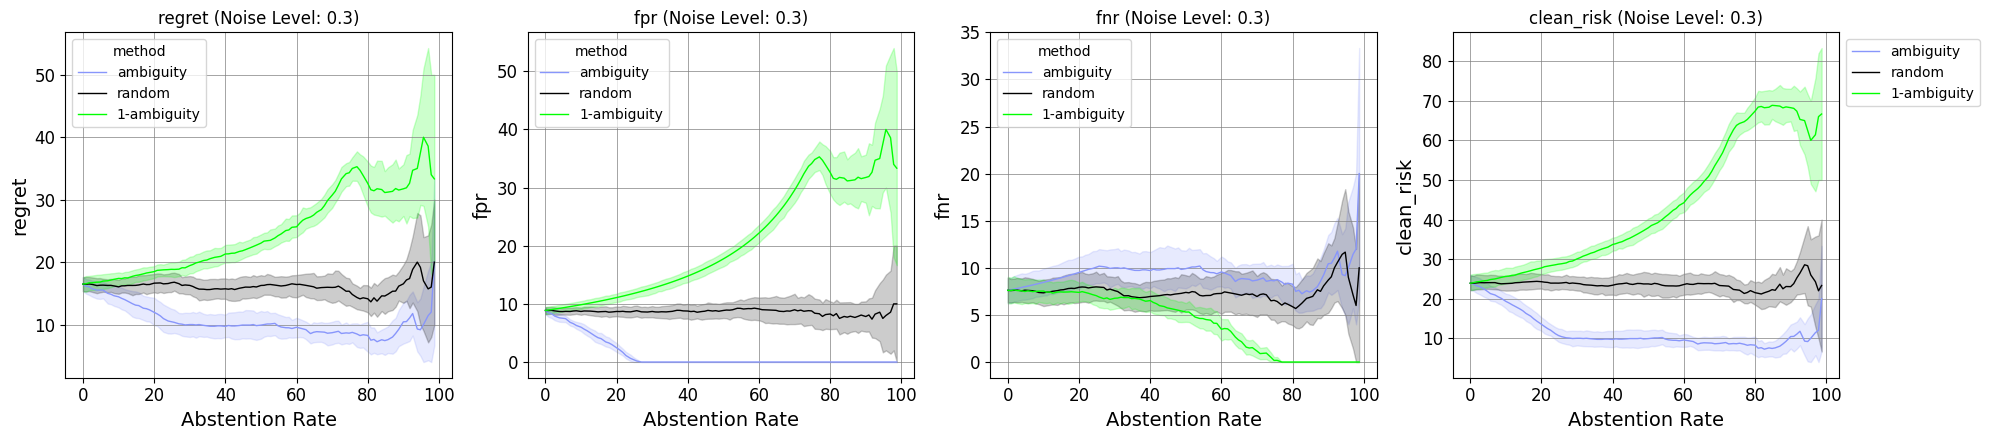

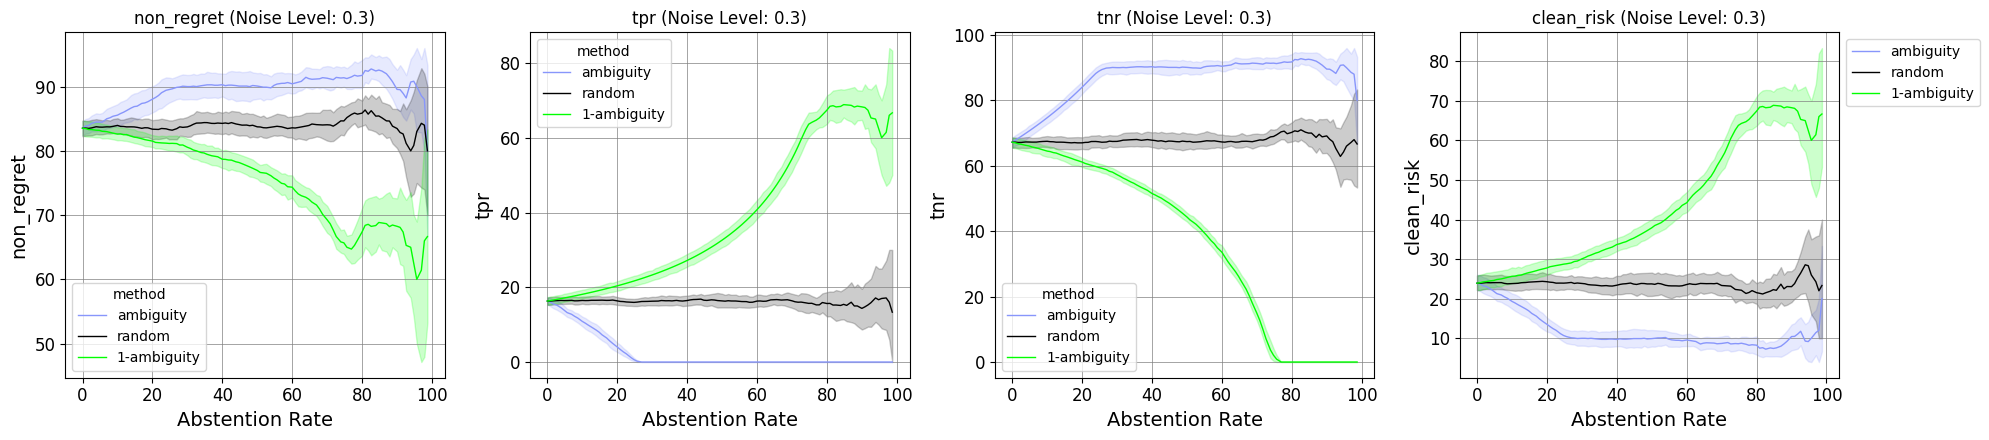

In [ ]:
for noise_level in [0.2, 0.3, 0.35, 0.4]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
        data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
        plot_abstain_toy(data, noise_level)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
                data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
                plot_abstain_toy(data, noise_level)

In [ ]:
count_metrics = ["X_counts", "y_counts", "u_counts"]

# Plot the distribution of X_counts, y_counts, yn_counts vs abstention rate using catplot
for count_metric in count_metrics:
    distribution_data = []

    metric_data = data[data['metric'] == count_metric]
    for index, row in metric_data.iterrows():
        abstention = row['abstention']
        counts = row['value']  # assuming the counts are stored in the 'value' column
        draw_id = row['draw_id']
        method = row['method']
        for key, value in counts.items():
            distribution_data.append({'abstention': abstention, 'instance': key, 'count': value, 'count_type': count_metric, 'draw_id':draw_id, 'method':method})

    distribution_df = pd.DataFrame(distribution_data)

    # Create instances_counts dictionary based on abstention == 0.0
    instances_counts = distribution_df[(distribution_df['abstention'] == 0.0)& (distribution_df['draw_id'] == distribution_df['draw_id'].min())].groupby('instance')['count'].sum().to_dict()

    distribution_df['normalized_count'] = distribution_df.apply(lambda row: row['count'] / instances_counts[row['instance']]*len(distribution_df.method.unique()), axis=1)

    fig, ax = plt.subplots(figsize=(7, 5))

    g = sns.lineplot(
        data=distribution_df, x="abstention", y="normalized_count", hue="instance", style ="method", palette="pastel", ax=ax)
    ax.set_title(f"{count_metric} vs Abstention Rate")
    ax.set_xlabel("Abstention Rate")
    ax.set_ylabel("Normalized Count")
    ax.legend(title='Instance')

        # Removing the style from the legend
    handles, labels = plt.gca().get_legend_handles_labels()


    plt.legend(handles[1:], labels[1:], title="", loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
data[data["metric"]=="X_counts"].value[7]

# 2D Regret

In [ ]:
# Define the deterministic labels for each (x1, x2) pair
true_labels = {
    (0, 0): 0,
    (0, 1): 1,
    (1, 0): 1,
    (1, 1): 1
}

# Define the number of instances for each (x1, x2) pair
instances_counts = {
    (0, 0): 10,
    (0, 1): 10,
    (1, 0): 10,
    (1, 1): 35
}


X, y = generate_dataset(true_labels, instances_counts)
labels = np.array(list(true_labels.values()))

In [ ]:
d = 2  # number of dimensions
m = 1000 #number of retrainings
n_draws = 1
max_iter = 1000
noise_type = "class_conditional"
loss_type = "0-1"


In [ ]:
metrics_dfs = []
instance_metrics_dfs = []
class_metrics_dfs = []

for noise_level in [0, 0.1, 0.2, 0.3, 0.4, 0.45, 0.49]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                toy_data_helper(d, X, y, noise_type, noise_level, T, n_draws, loss_type, 0.1, metrics_dfs, instance_metrics_dfs, class_metrics_dfs)

metrics_df = pd.concat(metrics_dfs)
instance_metrics_df = pd.concat(instance_metrics_dfs)
class_metrics_df = pd.concat(class_metrics_dfs)

In [ ]:
# Example usage
plot_regret_toy(metrics_df, instance_metrics_df, class_metrics_df)

# 2D Abstain

In [ ]:
for noise_level in [0.2, 0.3, 0.35, 0.4]:
    if noise_type == "class_independent":
        _, T = generate_class_independent_noise(y, noise_level)  # Fixed noise draw
        metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
        data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
        plot_abstain_toy(data, noise_level)
    elif noise_type == "class_conditional":
        fixed_classes = [0]
        fixed_noises = [0.0]

        for fixed_class in fixed_classes:
            for fixed_noise in fixed_noises:
                _, T = generate_class_conditional_noise(y, noise_level, fixed_class, fixed_noise)
                metrics_df =  abstain_toy(d, m, max_iter, X, y, noise_type, T, loss_type="0-1", n_draws=n_draws, epsilon=0.1)
                data = calculate_metrics_abstain_toy(metrics_df, noise_type=noise_type)
                plot_abstain_toy(data, noise_level)